# Predspracovanie údajov

In [2]:
# imports
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

## 1. Realizácia predspracovania dát

In [3]:
devices = pd.read_csv('data/devices_cleaned.csv')
profiles = pd.read_csv('data/profiles_cleaned.csv')

Načítanie súborov uložených v predošlej fáze zadania, ktoré sú už vyčistené a obsahujú hodnoty v správnom formáte.

In [4]:
connections = pd.read_csv('data/connections_cleaned.csv')
connections['ts'] = pd.to_datetime(connections['ts'])

processes = pd.read_csv('data/processes_cleaned.csv')
processes['ts'] = pd.to_datetime(processes['ts'])

conn_processes = pd.merge(connections, processes, on=['ts', 'imei', 'mwra'], how='inner')
conn_processes.drop_duplicates(inplace=True)

conn_processes.head(10)

,ts,imei,mwra,c.android.gm,c.android.youtube,c.katana,c.dogalize,c.android.chrome,c.android.vending,c.raider,...,p.dogalize,p.android.defcontainer,p.google,p.android.gms,p.olauncher,p.android.vending,p.browser.provider,p.process.gapps,p.gms.persistent,p.simulator
0,2018-05-05 10:00:00,3590433799317661073,1.0,10.73779,7.60358,10.30550,12.72137,17.14262,63.02014,52.99201,...,49.63998,52.22598,86.79731,88.93302,12.84506,2.63115,90.52801,90.51873,35.23943,93.56427
1,2018-05-05 10:01:00,3590433799317661784,1.0,13.88095,10.68630,8.36266,13.90403,13.28416,54.83081,41.20946,...,50.35593,45.19193,87.84568,25.99896,90.22100,71.68478,89.94562,71.77292,64.49298,42.81274
2,2018-05-05 10:02:00,863033069630348917,0.0,9.38536,16.17278,13.29120,5.79980,15.01395,49.94955,55.12888,...,51.05029,29.87061,59.48429,45.04187,1.58945,13.22444,88.76900,64.93572,45.52142,44.37595
3,2018-05-05 10:03:00,863033069630348339,1.0,7.29835,16.20768,9.73707,13.21535,9.59391,48.30890,65.90586,...,61.63920,86.63658,18.00165,20.65816,22.51564,28.59876,62.69179,34.25119,4.52876,72.11141
4,2018-05-05 10:04:00,3590433799317662212,0.0,12.68999,12.72589,6.94943,9.72027,16.11904,54.58740,50.94873,...,36.14104,41.29170,72.44112,93.65874,50.08215,38.17231,6.71236,72.23466,68.04155,33.38015
5,2018-05-05 10:05:00,3590433799317662089,0.0,12.99176,9.65605,15.29269,10.39870,12.51173,39.46274,30.66447,...,48.60392,87.32552,59.15043,62.04534,75.64869,4.51152,0.98024,81.73171,23.89307,14.14834
6,2018-05-05 10:06:00,863033069630348552,1.0,11.79414,12.74222,10.02213,12.05077,13.89371,51.77089,48.57521,...,48.46851,29.00829,28.58623,86.68517,9.49859,48.85382,63.61849,12.79003,94.08635,43.47113
7,2018-05-05 10:07:00,8630330696303481925,1.0,8.81652,12.14479,8.71200,13.26715,11.86095,68.75125,59.36714,...,56.40727,95.00967,14.71936,73.81036,80.19382,47.06788,69.95997,8.18354,31.40807,15.22640
8,2018-05-05 10:08:00,8630330696303482204,1.0,9.62259,14.23347,7.07644,13.28015,12.56443,75.45829,51.36138,...,48.01488,58.59695,22.39255,36.39143,0.58749,40.95247,57.91894,97.39154,1.13396,23.35486
9,2018-05-05 10:09:00,3590433799317661669,1.0,9.93325,11.92854,9.84673,12.45888,13.17211,67.88903,57.55240,...,58.39881,65.31695,34.69885,84.58720,41.58930,78.39567,69.73297,15.35551,16.26502,14.02912


### Mergovanie
Súbory connections a processes sme sa rozhodli spojiť na základe troch spoločných atribútov: **imei, tsa, mwra**. Tento krok nám umožňuje ďalej pracovať už iba s jednou tabuľkou.

### (A)

In [5]:
X = conn_processes.drop(columns=['mwra'])
y = conn_processes['mwra']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_copy = X_train.copy()

print(f'Train Dataset Shape: ', X_train.shape, y_train.shape)
print(f'Test Dataset Shape: ', X_test.shape, y_test.shape)

Train Dataset Shape:  (11835, 32) (11835,)
Test Dataset Shape:  (2959, 32) (2959,)


### Rozdelenie na trénovaciu a testovaciu množinu

**X:** dataframe so všetkými atribútmi okrem predikovanej premennej

**y:** séria hodnôt predikovanej premennej v zachovanom poradí

Rozdelenie sme uskutočnili v klasickom pomere **80:20**. Kedže súbor má približne 14000 záznamov, tento pomer nám zaručuje dostatočné množstvo záznamov pre trénovanie, a taktiež pre zmysluplné testovanie.

Hodnota _random\_state=42_ nemá žiadny špeciálny význam a je tu použitá, aby rozdelenie na trénovaciu a testovaciu množinu bolo pri každom spustení rovnaké.

Rozdelenie sme uskutočnili iba pri súbore **conn_processes**, ktorý sa ako jediný bude používat v ostatných častiach projektu.

### (B)

#### Kódovanie atribútov
V nasledujúcej časti budeme kódovať predovšetkým kategorické atribúty súborov **devices** a **profiles**, ktoré ale už v ďalších častiach projektu nebudeme využívať, pretože je nemožné ich rozumne spojiť s hlavnou tabuľkou **conn_processes** (hodnota atribútu _imei_, čo by mal byť jedinečný identifikátor sa nachádza duplicitne vo viacerých záznamoch). Taktiež atribúty v týchto dvoch súboroch nemajú podľa nášho uváženia signifikantný vplyv na vývoj predikovanej premennej.

Aj keď tieto datasety momentálne nie sú určené na tréning modelu, ich kódovanie umožňuje ich jednoduchú integráciu do strojového učenia v prípade potreby, alebo pre použitie na rozšírenú analýzu.

In [6]:
def hash_md5(value):
    hash_object = hashlib.md5(value.encode())
    hash_int = int(hash_object.hexdigest(), 16)
    return hash_int % (2 ** 63)

##### conn_processes

In [7]:
non_numeric = X_train_copy.select_dtypes(exclude=['number']).columns.to_list()
print('Non-numeric columns:', non_numeric)

Non-numeric columns: ['ts']


Jediný atribút v tomto súbore, ktorý nemal numerický typ bol **ts**. Tento atribút predstavujúci čas sme premenili na celkový počet nanosekúnd od UNIX epochy.

In [8]:
X_train_copy['ts'] = X_train_copy['ts'].astype('int64')

print('Column types in order:', X_train_copy.dtypes.to_list())
X_train_copy.head(2)

Column types in order: [dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64')]


,ts,imei,c.android.gm,c.android.youtube,c.katana,c.dogalize,c.android.chrome,c.android.vending,c.raider,c.UCMobile.intl,...,p.dogalize,p.android.defcontainer,p.google,p.android.gms,p.olauncher,p.android.vending,p.browser.provider,p.process.gapps,p.gms.persistent,p.simulator
10308,1526133600000000000,3590433799317661545,15.07576,10.24261,12.55076,10.81983,16.56803,51.08433,55.40703,42.16911,...,59.00193,15.19691,24.61623,47.64864,36.44968,75.69554,0.81417,10.06329,35.59590,4.49113
10797,1526162700000000000,359043379931766635,11.47352,11.52160,14.50189,9.98012,14.12950,70.55549,66.92780,16.73113,...,60.71290,33.17497,83.04305,45.18686,27.33930,61.00963,77.18931,84.50057,46.84404,93.53882


##### devices

In [9]:
non_numeric = devices.select_dtypes(exclude=['number']).columns.to_list()
print('Non-numeric columns:', non_numeric)

Non-numeric columns: ['store_name', 'code', 'continent', 'city']


Atribút **code** sme sa rozhodli premeniť pomocou label encodingu, kedy každej unikátnej hodnote bolo priradené číslo. Dôvodom bolo, že celkový počet unikátnych hodnôt je okolo 130 a často sa opakujú.

Atribút **continent** sme riešili pomocou one hot encodingu, pretože obsahuje veľmi málo unikátnych hodnôt.

Atribút **city** sme zakódovali frequency encodingom, keďže lokalita bola širšie rozdelená podľa kontinentu a tento typ je vhodnejší pre modely a štatistické účely.

Atribút **store_name** sme zahashovali pomocou _md5 algoritmu_, nakoľko obsahoval takmer unikátne hodnoty.

In [10]:
devices['code'], code_unique = pd.factorize(devices['code'])
devices = pd.get_dummies(devices, columns=['continent'], prefix='continent')

for col in devices.columns:
    if col.startswith('continent_'):
        devices[col] = devices[col].astype(int)

devices['store_name'] = devices['store_name'].apply(hash_md5)

frequency = devices['city'].value_counts()
devices['city'] = devices['city'].map(frequency)

print('Column types in order:', devices.dtypes.to_list())
devices.head(2)

Column types in order: [dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64')]


,latitude,longitude,store_name,code,imei,city,continent_Africa,continent_America,continent_Asia,continent_Atlantic,continent_Australia,continent_Europe,continent_Indian,continent_Pacific
0,15.58552,102.42587,1238261730008270783,0,3590433799317661925,36,0,0,1,0,0,0,0,0
1,52.59319,13.32127,3703756712017643536,1,8630330696303482139,136,0,0,0,0,0,1,0,0


#### profiles

In [11]:
non_numeric = profiles.select_dtypes(exclude=['number']).columns.to_list()
print('Non-numeric columns:', non_numeric)

Non-numeric columns: ['residence', 'username', 'name', 'ssn', 'registration', 'address', 'company', 'mail', 'latitude', 'longitude', 'domain']


Odstránili sme atribúty **residence**, **username**, **name** a **mail** pretože sú nepodstatné pre naše pozorovanie.

Atribúty **latitude** a **longitude** sme premenili na numerické hodnoty a chýbajúce hodnoty sme nahradili s 0.

Atribút **registration** sme premenili na počet nanosekúnd od UNIX epochy.

Z atribútu **ssn** sme odstránili pomlčky.

Atribút **address** sme premenili na binárny atribút, podľa toho, či záznam obsahoval skutočnú adresu.

Atribút **company** sme zahashovali pomocou _md5 algoritmu_, nakoľko obsahoval takmer unikátne hodnoty.

Atribút **domain** sme riešili pomocou one hot encodingu, pretože obsahuje veľmi málo unikátnych hodnôt.

In [12]:
profiles.drop(['residence', 'username', 'name', 'mail'], inplace=True, axis=1)

profiles['latitude'] = profiles['latitude'].replace('Unknown', 0)
profiles['longitude'] = profiles['longitude'].replace('Unknown', 0)

profiles['latitude'] = profiles['latitude'].astype(float)
profiles['longitude'] = profiles['longitude'].astype(float)

profiles['registration'] = pd.to_datetime(profiles['registration'], format='%m/%d/%Y')
profiles['registration'] = (profiles['registration']).astype(int)

def convert_ssn(value):
    cleaned = ''.join(filter(str.isdigit, value))
    return int(cleaned)

profiles['ssn'] = profiles['ssn'].apply(convert_ssn)

def encode_address(value):
    return 0 if value == 'Unknown' else 1

profiles['address'] = profiles['address'].apply(encode_address)
profiles['company'] = profiles['company'].apply(hash_md5)

profiles = pd.get_dummies(profiles, columns=['domain'], prefix='domain')

for col in profiles.columns:
    if col.startswith('domain_'):
        profiles[col] = profiles[col].astype(int)

print('Column types in order:', devices.dtypes.to_list())
profiles.head(2)

Column types in order: [dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64')]


,imei,ssn,registration,address,company,user_id,latitude,longitude,domain_gmail.com,domain_hotmail.com,domain_yahoo.com
0,359043379931766536,380331115,1667260800000000000,1,2562683759997207315,322,29.254521,56.881839,0,1,0
1,3590433799317662154,244952123,1701129600000000000,1,8266524727329204724,1634,-73.824535,-147.436751,0,1,0


Rozhodli sme sa z trénovacieho datasetu odstrániť aj stĺpce **imei** a **ts** pretože žiadnym spôsobom neovplyvňujú vývoj predikovanej premennej _mwra_. 

In [13]:
X_train_copy.drop(['ts', 'imei'], inplace=True, axis=1)

In [14]:
def fill_missing_values(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())

    return df

def outlier_replacement(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        lower_bound = df[col].quantile(0.05)
        upper_bound = df[col].quantile(0.95)

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

Aj keď by náš konkretný dataset nemal obsahovať vychýlene alebo chýbajúce hodnoty pretože boli nahradené v predchádzajúcej fáze, rohodli sme sa pridať funkcie na ich konotrolu pre pripravenosť na zmeny dát v budúcnosti a štandardizáciu prístupu.

_Chýbajúce hodnoty_ nahrádzame pomocou **mediánu**, pretože podľa minulých pozorovaní hodnoty väčšinou nie sú normálne distribuované.

_Vychýlené hodnoty_ nahrádzame hraničnými hodnotami **5 a 95 percentilu**, pretože ich odstránenie by podľa minulých pozorovaní malo výrazný vplyv.

In [15]:
X_train_copy = fill_missing_values(X_train_copy)
X_train_copy = outlier_replacement(X_train_copy)

### (C)

In [16]:
standard_columns, minmax_columns, power_columns, quantile_columns = [], [], [], []

def select_transformer(column):
    skewness = column.skew()
    negative_values = (column < 0).any()
    
    iqr = column.quantile(0.75) - column.quantile(0.25)
    range = column.max() - column.min()
    large_range = range > iqr * 2
    
    if abs(skewness) >= 1.5 and not negative_values:
        power_columns.append(column.name)
        return
    
    if (column.max() > 1 or column.min() < 0) and (0.25 < abs(skewness) < 1.5):
        minmax_columns.append(column.name)
        return
    
    if large_range or (0.25 < abs(skewness) < 1.5):
        quantile_columns.append(column.name)
        return
    
    if abs(skewness) <= 0.25:
        standard_columns.append(column.name)
        return

for col in X_train_copy.columns:
    select_transformer(X_train_copy[col])

print('StandardScaler Columns:\t\t', standard_columns)
print('MinMaxScaler Columns:\t\t', minmax_columns)
print('PowerTransformer Columns:\t', power_columns)
print('QuantileTransformer Columns:\t', quantile_columns)

StandardScaler Columns:		 ['c.UCMobile.intl', 'c.updateassist', 'c.UCMobile.x86', 'p.android.defcontainer', 'p.google', 'p.android.gms', 'p.olauncher', 'p.android.vending', 'p.browser.provider', 'p.process.gapps', 'p.gms.persistent', 'p.simulator']
MinMaxScaler Columns:		 ['p.android.chrome', 'p.android.documentsui', 'p.android.gm']
PowerTransformer Columns:	 ['p.notifier']
QuantileTransformer Columns:	 ['c.android.gm', 'c.android.youtube', 'c.katana', 'c.dogalize', 'c.android.chrome', 'c.android.vending', 'c.raider', 'p.system', 'p.android.externalstorage', 'p.android.packageinstaller', 'p.android.settings', 'p.inputmethod.latin', 'p.katana', 'p.dogalize']


#### Transformácia dát

Na transformáciu dát pre strojové učenie sme sa rozhodli použiť 4 metódy a rozdeliť jednotlivé atribúty do 4 skupín, podľa toho aký transformer/scaler najviac vyhovuje ich hodnotám:

**PowerTransformer:** Ak má atribút vysokú hodnotu skewness a neobsahuje záporné hodnoty.

**MinMaxScaler:** Ak má atribút hodnoty <0 alebo >1 a zároveň mierne zvýšenú hodnotu skewness.

**QuantileTransformer:** Ak má atribút vysoký rozptyl, alebo mierne zvýšenú hodnotu skewness.

**StandardScaler:** Ak má atribút nízku hodnotu skewness, dáta majú relatívne normálnu distribúciu,


In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('minmax', MinMaxScaler(), minmax_columns),
        ('power', PowerTransformer(method='yeo-johnson'), power_columns),
        ('quantile', QuantileTransformer(output_distribution='normal'), quantile_columns)
    ],
    remainder='passthrough'
)

X_train_transformed = preprocessor.fit_transform(X_train_copy)

### (D)

#### Zdokumentovanie
Rozhodli sme sa pokračovať v projekte už iba so spojeným súborom **conn_processes**, pretože ostatné súbory pre nás neboli dôležité a nedali sa rozumne využiť. Data encoding sme použili pri všetkých súboroch, aby v prípade potreby boli pripravené na ďalšie spracovanie.

Súbor **conn_processes** bol rozdelený na trénovaciu a testovaciu množinu v pomere _80:20_. V ďalších úlohách sme pokračovali s trénovacím datasetom.

Atribúty nášho skúmaného súboru sme pretransformovali na hodnoty pre strojové učenie pomocou zvolených štyroch metód. Použili sme pritom ColumnTransformer.

## 2. Výber atribútov pre strojové učenie

### (A)
#### 3.3.1 Výber informatívnych atribútov k predikovanej premennej pre strojové učenie

##### Metóda pomocou random forest

<Figure size 1200x800 with 0 Axes>

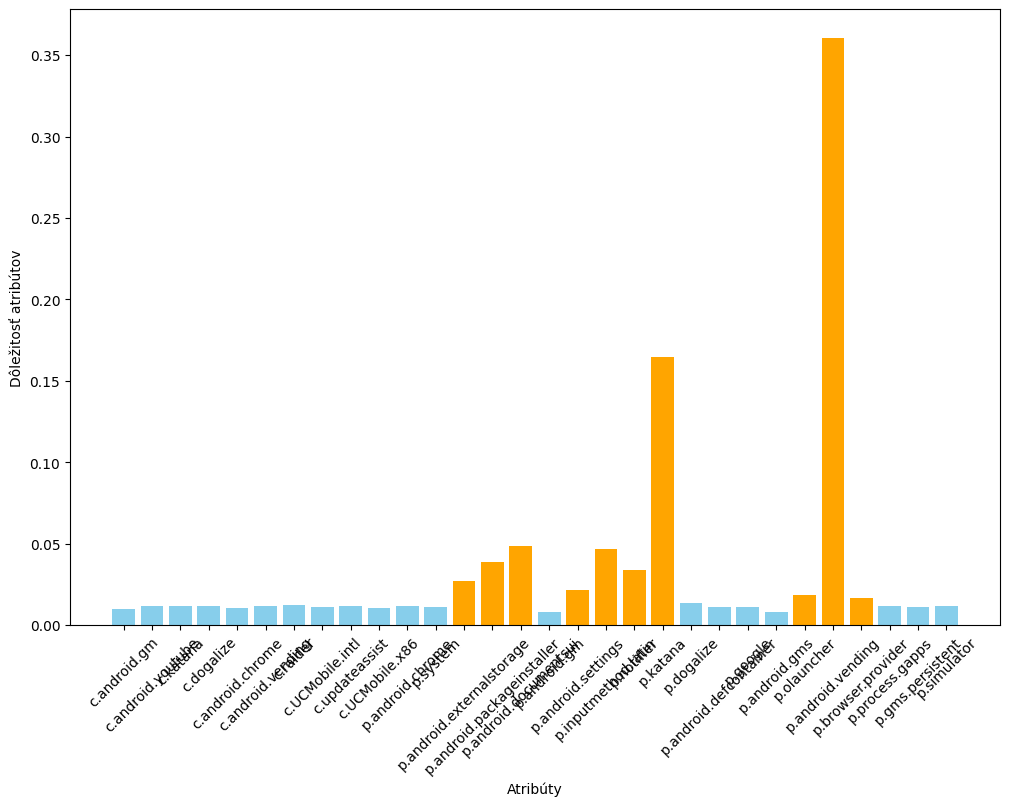

In [18]:
rf = RandomForestRegressor()
rf.fit(X_train_transformed, y_train)

feature_names = [col for col in X_train.columns if col not in ['ts', 'imei']]
feature_importances = rf.feature_importances_

df_rf = pd.DataFrame({
    "Nazov atributu": feature_names,
    "Random Forest hodnota": feature_importances
})

rf_features = df_rf.nlargest(10, "Random Forest hodnota")

rf_features = pd.Series(
    data=rf_features["Random Forest hodnota"].values,
    index=rf_features["Nazov atributu"].values
)

plt.figure(figsize=(12, 8))
colors = ["skyblue" if feature not in rf_features else "orange" for feature in df_rf["Nazov atributu"]]

plt.figure(figsize=(12, 8))
plt.bar(df_rf["Nazov atributu"], df_rf["Random Forest hodnota"], color=colors)
plt.ylabel("Dôležitosť atribútov")
plt.xlabel("Atribúty")
plt.xticks(rotation=45)
plt.show()

##### Metóda pomocou Lasso Regression

10 najdôležitejších atribútov pomocou Lasso Regression: 

p.android.packageinstaller    0.290347
p.katana                      0.063901
p.browser.provider            0.039741
p.android.externalstorage     0.020659
p.dogalize                    0.003144
p.android.gms                -0.009039
p.olauncher                  -0.015172
p.inputmethod.latin          -0.023884
p.notifier                   -0.042257
p.android.vending            -0.046368
dtype: float64


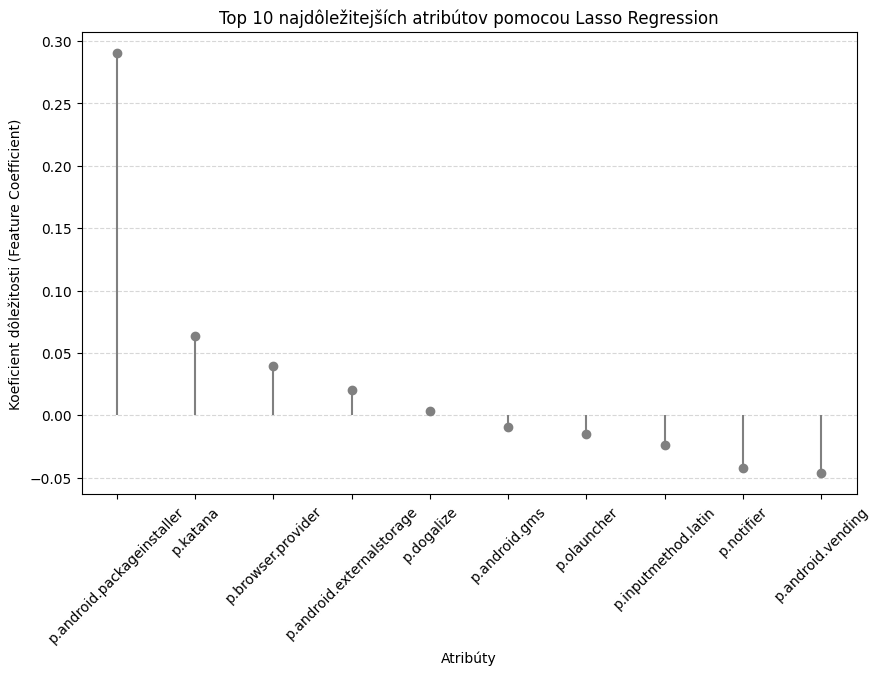

In [19]:
lasso = Lasso(alpha=0.01) 
lasso.fit(X_train_transformed, y_train)

importance = pd.Series(lasso.coef_, index=[col for col in X_train.columns if col not in ['ts', 'imei']])

lasso_features = importance[importance != 0].nlargest(10)

print("10 najdôležitejších atribútov pomocou Lasso Regression: \n")
print(lasso_features.head(10))

plt.figure(figsize=(10, 6))
plt.stem(lasso_features.index, lasso_features.values, linefmt="grey", markerfmt="o", basefmt=" ")
plt.xlabel("Atribúty")
plt.ylabel("Koeficient dôležitosti (Feature Coefficient)")
plt.title("Top 10 najdôležitejších atribútov pomocou Lasso Regression")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Metóda pomocou Select from model

10 najdôležitejších atribútov pomocou Select from model: 

p.android.gms                0.156314
p.inputmethod.latin          0.141494
p.android.settings           0.106290
p.android.externalstorage    0.067006
p.system                     0.066642
p.android.gm                 0.059726
p.google                     0.038502
p.olauncher                  0.035191
p.android.chrome             0.034485
p.android.documentsui        0.031489
dtype: float64


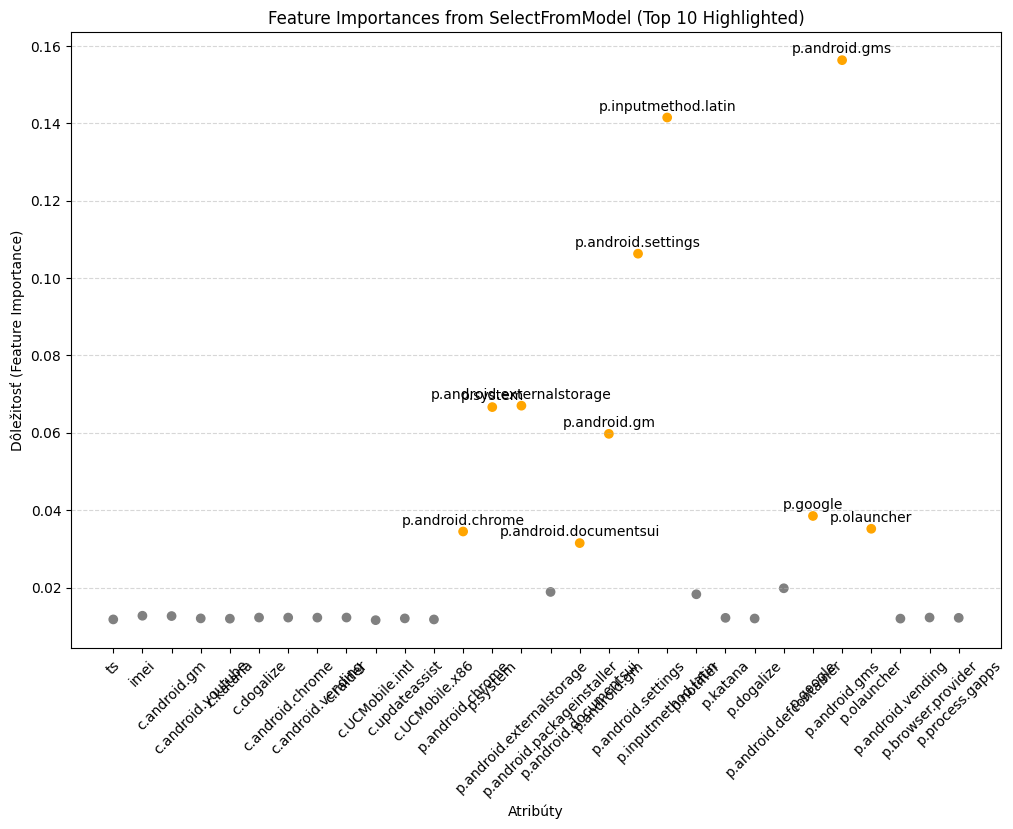

In [20]:
feature_names = X_train.columns[:X_train_transformed.shape[1]]

model = RandomForestClassifier()
model.fit(X_train_transformed, y_train)

selector = SelectFromModel(model, threshold=0, prefit=True)
X_selected = selector.transform(X_train_transformed)

selected_features_mask = selector.get_support()

selected_feature_names = feature_names[selected_features_mask]

selected_feature_importances = model.feature_importances_[selected_features_mask]

importance = pd.Series(selected_feature_importances, index=selected_feature_names)

select_from_model_features = importance.nlargest(10)

print("10 najdôležitejších atribútov pomocou Select from model: \n")
print(select_from_model_features)

plt.figure(figsize=(12, 8))
all_features = importance.index
all_importances = importance.values

colors = ["orange" if feature in select_from_model_features.index else "grey" for feature in all_features]
plt.scatter(all_features, all_importances, color=colors)
plt.xticks(rotation=45)
plt.xlabel("Atribúty")
plt.ylabel("Dôležitosť (Feature Importance)")
plt.title("Feature Importances from SelectFromModel (Top 10 Highlighted)")
plt.grid(axis='y', linestyle='--', alpha=0.5)

for feature, importance_value in select_from_model_features.items():
    plt.annotate(f"{feature}", (feature, importance_value), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

### (B)

In [21]:
all_features = set(rf_features.keys()) | set(lasso_features.keys()) | set(select_from_model_features.keys())

data = []
for feature in all_features:
    rf_value = rf_features.get(feature, "---")
    lasso_value = lasso_features.get(feature, "---")
    select_from_model_value = select_from_model_features.get(feature, "---")
    data.append((feature, rf_value, lasso_value, select_from_model_value))

df_combined = pd.DataFrame(data, columns=["Nazov atributu", "Random Forest hodnota", "Lasso hodnota", "Select from model hodnota"])
df_combined["Random Forest hodnota"] = pd.to_numeric(df_combined["Random Forest hodnota"], errors='coerce')
df_combined["Lasso hodnota"] = pd.to_numeric(df_combined["Lasso hodnota"], errors='coerce')

df_combined.sort_values(by="Random Forest hodnota", ascending=False, inplace=True)


df_combined.replace("x", 0, inplace=True)

df_combined["Select from model hodnota"] = pd.to_numeric(df_combined["Select from model hodnota"], errors='coerce')
df_combined["Select from model hodnota"] = df_combined["Select from model hodnota"]

df_combined["Výsledná hodnota"] = (
    pd.to_numeric(df_combined["Random Forest hodnota"], errors='coerce').fillna(0)
    + pd.to_numeric(df_combined["Lasso hodnota"], errors='coerce').fillna(0)
    + df_combined["Select from model hodnota"].fillna(0)
)

df_combined.sort_values(by="Výsledná hodnota", ascending=False, inplace=True)
df_combined.fillna(0, inplace=True)
print("Kombinovaná tabuľka atribútov podľa dôležitosti: \n")
print(df_combined.to_string(index=False))

Kombinovaná tabuľka atribútov podľa dôležitosti: 

            Nazov atributu  Random Forest hodnota  Lasso hodnota  Select from model hodnota  Výsledná hodnota
p.android.packageinstaller               0.038757       0.290347                   0.000000          0.329105
         p.android.vending               0.360211      -0.046368                   0.000000          0.313844
                  p.katana               0.164538       0.063901                   0.000000          0.228439
       p.inputmethod.latin               0.047001      -0.023884                   0.141494          0.164610
             p.android.gms               0.000000      -0.009039                   0.156314          0.147274
        p.android.settings               0.021320       0.000000                   0.106290          0.127610
 p.android.externalstorage               0.026941       0.020659                   0.067006          0.114607
     p.android.documentsui               0.048647       0.000000     

### (C)

Použitie viacerých metód na zistenie dôležitosti atribútov pri výbere najvhodnejších premenných na modelovanie je dôležité, pretože každá z týchto metód vyhodnocuje dôležitosť atribútov iným spôsobom. Týmto prístupom môžeme získať robustnejší a lepší pohľad na to, ktoré atribúty sú skutočne dôležité.

---

### 1. **Random Forest**

- **Prečo bola táto metóda použitá?**
  - Random Forest je silná a flexibilná metóda strojového učenia, ktorá sa bežne používa na klasifikáciu aj regresiu. Je známa svojou schopnosťou zvládnuť veľké množstvo atribútov a komplexné vzťahy medzi nimi. Používa sa preto, že jej výstupy sú stabilnejšie a menej náchylné na pretrénovanie v porovnaní s jednotlivými rozhodovacími stromami. Random Forest tiež poskytuje prirodzený spôsob na výpočet dôležitosti atribútov, čo je cenné pri výbere atribútov v strojovom učení.
- **Ako funguje?**
  - Random Forest vypočíta dôležitosť atribútov na základe toho, ako často sa každý atribút používa na rozdelenie uzlov v rozhodovacích stromoch a ako veľmi tieto rozdelenia zlepšujú predikciu (napr. znížením Giniho indexu alebo chyby). Atribúty, ktoré významne zlepšujú predikčný výkon stromov, sú považované za dôležitejšie.
<br><br>
---

### 2. **Lasso Regression (L1 Regularization)**

- **Prečo bola táto metóda použitá?**
  - Lasso Regression je efektívna metóda na výber atribútov a ich regularizáciu, čo znamená, že automaticky zmenšuje koeficienty atribútov, ktoré nie sú informatívne, na nulu. To je veľmi užitočné, keď máte veľa atribútov, a potrebujete určiť, ktoré z nich sú skutočne dôležité pre predikciu. Použitie Lasso Regression môže taktiež zlepšiť generalizáciu modelu a zabrániť pretrénovaniu.
- **Ako funguje?**
  - Lasso Regression pridáva k chybovej funkcii penalizáciu za veľkosť koeficientov. Táto penalizácia núti model preferovať jednoduchšie modely s menším počtom atribútov. Atribúty, ktoré majú veľmi malý alebo nulový vplyv na predikciu, sú odstránené (ich koeficienty sú zmenšené na nulu).
<br>
<br>
---

### 3. **SelectFromModel**

- **Prečo bola táto metóda použitá?**
  - SelectFromModel je všestranná technika na výber atribútov, ktorá využíva výsledky modelu strojového učenia na identifikáciu najdôležitejších atribútov. Je to flexibilná metóda, ktorá môže pracovať s rôznymi modelmi na základe toho, ktorý model najlepšie zodpovedá charakteru dát. Táto flexibilita umožňuje prispôsobenie techniky špecifikám problému, čo môže viesť k lepšiemu výberu atribútov.
- **Ako funguje?**
  - SelectFromModel trénuje zadaný model na dátach a potom použije kritérium (napr. prah dôležitosti) na výber atribútov. Atribúty, ktoré neprekročia tento prah, sú odstránené.

<br>
<br>

---

Výsledné hodnoty jednotlivých metód sme následne spočítali, zapísali do tabulky a na základe výslednej hodnoty zoradili tabuľku podľa atribútov s najvyššou hodnotou. 
Súhrnné výsledky a porovnanie najdôležitejších atribútov z rôznych metód výberu funkcií umožňujú identifikovať kľúčové premenné, ktoré majú najväčší vplyv na predikciu. Zjednodušujú model, zvyšujú jeho interpretovateľnosť a znižujú riziko pretrénovania. Taktiež poskytujú rôzne pohľady na dôležitosť atribútov, čo pomáha posúdiť robustnosť modelu. Zoradenie atribútov podľa výsledných hodnôt umožňuje jednoduchšie identifikovať tie, ktoré prispievajú k najlepším predikciám.

## 3. Replikovateľnosť predspracovania

### (A)

In [22]:
def encode_values(df):
    df['ts'] = df['ts'].astype('int64')
    return df

def remove_attributes(df):
    df = df.drop(['ts', 'imei'], axis=1)
    return df
    
encoder_transformer = FunctionTransformer(func=encode_values, validate=False)
removal_transformer = FunctionTransformer(func=remove_attributes, validate=False)
inputer_transformer = FunctionTransformer(func=fill_missing_values, validate=False)
outliers_transformer = FunctionTransformer(func=outlier_replacement, validate=False)

Operácie na zakódovanie nenumerických atribútov a odstránenie nepotrebných atribútov sme presunuli do vlastnej funkcie, aby ich bolo neskôr možné použiť v jednom kroku v data pipeline. Funkcie na vyplnenie chýbajúcich hodnôt a ošetrenie vychýlených hodnôt boli už vo vlastnej funkcii.

Všetky tieto funkcie sme zaobalili do triedy _FunctionTransformer_, aby boli vo vhodnom formáte pre pipeline. Takéto funkcie musia prijímať aj vraciať dataframe. Tento problém by sa dal riešiť aj pomocou vlastných tried, ale zvolený spôsob bol pre nás výhodnejší, kedže niektoré funkcie už existovali pred replikovaním.

### (B)

In [23]:
pipeline = Pipeline(steps=[
    ('encoding', encoder_transformer),
    ('removing', removal_transformer),
    ('outliers', outliers_transformer),
    ('inputer', inputer_transformer),
    ('preprocessor', preprocessor)
])

Vytvorili sme data pipeline, ktorý vo svojich krokoch obsahuje všetky transformery typu _FunctionTransformer_ a takisto preprocessor z časti 1.C, ktorý pomocou _ColumnTransformera_ upraví hodnoty atribútov pre strojové učenie.

Na nezmenený trénovací dataset sme použili metódu **fit_transform** a následne na testovací dataset **transform**.

In [24]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

<small>Percentuálny podiel práce členov na projekte: Vlastislav Pokorný: 50%, Leon Radó: 50%</small>